# XGBoost Model for Homeless Prediction

Ziqi Wang

In [ ]:
# !pip install hyperopt
# !pip install xgboost


In [7]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Load Data

Data has been standardized

In [2]:
X_train = pd.read_csv("../data/scaled_X_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

In [4]:
# Drop 'year' column
X_train = X_train.drop(columns = "year")
X_test = X_test.drop(columns = "year")

In [5]:
X_train.head()

,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


# XG Boost Without Hyperparameter Tuning

In [8]:
params = {'random_state': 42,
            'colsample_bytree': 0.5,
             'eta': 0.3,
             'eval_metric': 'rmse',
             'max_depth': 5,
             'min_child_weight': 10,
             'n_estimators': 500,
             'objective': 'reg:squarederror',
             'subsample': 0.8}

xg_model = XGBRegressor(**params)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [9]:
# prediction
y_train_pred = xg_model.predict(X_train)
y_test_pred = xg_model.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = xg_model.score(X_train, y_train)
test_r2 = xg_model.score(X_test, y_test)

print("XGBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{train_r2:.4f}")
print(f"\tTest R-squared\t{test_r2:.4f}")

XGBoost Regressor results:

	Train MSE	0.0001
	Test MSE	0.4171

	Train R-squared	0.9999
	Test R-squared	0.4013


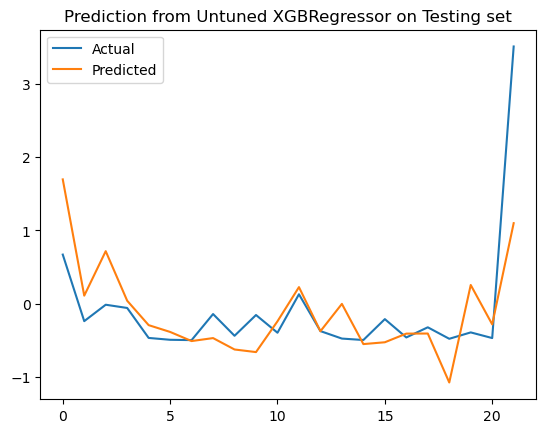

In [11]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred, label="Predicted")
plt.title("Prediction from Untuned XGBRegressor on Testing set")
plt.legend()
plt.show()


# Hyperparameter Tuning with Hypopt

In [14]:
# !!! This code cell takes about 10mins to run
warnings.filterwarnings('ignore')

# space for hyperparameter tuning
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 20, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(10, 1000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'eta':hp.quniform('eta', 0.1, 0.3, 0.1),
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
        }

hypopt_scores = []

def score(params):
    model = XGBRegressor(**params)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    hypopt_scores.append(score**2)
    
    return {'loss': score, 'status': STATUS_OK}    

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)


100%|█████| 1000/1000 [05:05<00:00,  3.27trial/s, best loss: 0.2297667204115552]


{'colsample_bytree': 0.8,
 'eta': 0.30000000000000004,
 'eval_metric': 'rmse',
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 540,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

## Fit the model with the best hyperparameters

In [18]:
best_params = {'random_state': 42,
               'colsample_bytree': 0.8,
                 'eta': 0.30000000000000004,
                 'eval_metric': 'rmse',
                 'max_depth': 3,
                 'min_child_weight': 4,
                 'n_estimators': 540,
                 'objective': 'reg:squarederror',
                 'subsample': 0.9}

best_xgmodel = XGBRegressor(**best_params)
best_xgmodel.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30000000000000004, eval_metric='rmse', feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=540, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [19]:
# prediction
y_train_pred_best = best_xgmodel.predict(X_train)
y_test_pred_best = best_xgmodel.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse_best = mean_squared_error(y_train, y_train_pred_best)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)

train_r2_best = best_xgmodel.score(X_train, y_train)
test_r2_best = best_xgmodel.score(X_test, y_test)

print("Hyperparameter Tuned XGBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_best,
        test_mse_best,
    )
)

print(f"\tTrain R-squared\t{train_r2_best:.4f}")
print(f"\tTest R-squared\t{test_r2_best:.4f}")

Hyperparameter Tuned XGBoost Regressor results:

	Train MSE	0.0000
	Test MSE	0.1363

	Train R-squared	1.0000
	Test R-squared	0.8043


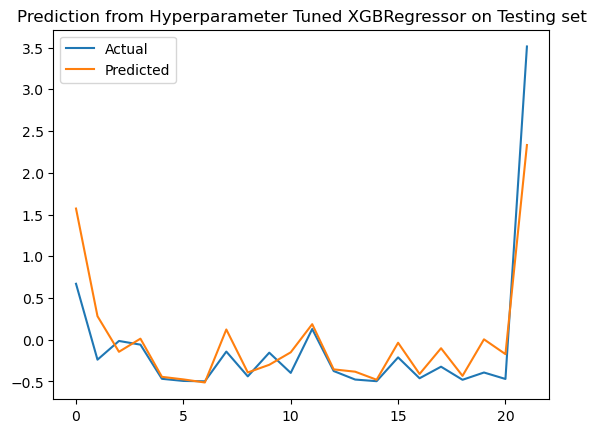

In [20]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred_best, label="Predicted")
plt.title("Prediction from Hyperparameter Tuned XGBRegressor on Testing set")
plt.legend()
plt.show()


# Feature Importance

The plot below shows feautre importance in terms of the number of times a feature appears in a tree. 

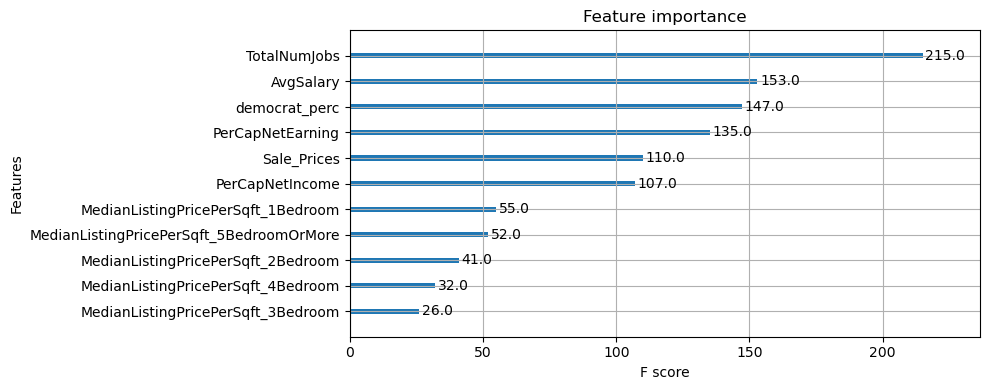

In [32]:
fig, ax = plt.subplots(figsize = (10, 4))
xgb.plot_importance(best_xgmodel, importance_type='weight', ax = ax)
plt.tight_layout()